In [ ]:
import os
import zipfile
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedShuffleSplit
from collections import Counter
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import (
    Input, Bidirectional, LSTM, Conv1D, MaxPooling1D, GlobalAveragePooling1D,
    Dropout, Dense, BatchNormalization, Attention, Concatenate, Add, LayerNormalization
)
from tensorflow.keras.models import Model

In [ ]:
# ========== STEP 1: Extract ==============
zip_folder = "/content/drive/MyDrive/T4 guardian project"
extract_path = "/content/CSI_HAR_dataset"
os.makedirs(extract_path, exist_ok=True)

for filename in os.listdir(zip_folder):
    if filename.endswith('.zip'):
        zip_path = os.path.join(zip_folder, filename)
        activity_name = os.path.splitext(filename)[0]
        activity_extract_path = os.path.join(extract_path, activity_name)
        os.makedirs(activity_extract_path, exist_ok=True)
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(activity_extract_path)

In [ ]:
# ========== STEP 2: Enhanced Data Loading & Preprocessing ============
def normalize_csi(data):
    """Apply advanced normalization to CSI data"""
    # Z-score normalization per subcarrier
    mean = np.mean(data, axis=0, keepdims=True)
    std = np.std(data, axis=0, keepdims=True) + 1e-8
    return (data - mean) / std

def pad_or_truncate(array, target_shape=(500, 90)):
    """Pad or truncate CSI data to a fixed size with improved padding"""
    padded = np.zeros(target_shape, dtype=np.float32)
    h, w = array.shape
    t_min = min(h, target_shape[0])
    f_min = min(w, target_shape[1])
    padded[:t_min, :f_min] = array[:t_min, :f_min]

    # Handle edge cases with reflection padding instead of zeros
    if h < target_shape[0]:
        reflection_size = min(h, target_shape[0] - h)
        padded[h:h+reflection_size, :f_min] = np.flip(array[:reflection_size, :f_min], axis=0)

    return padded

def apply_data_augmentation(X, y):
    """Apply data augmentation techniques to balance the dataset"""
    augmented_X = []
    augmented_y = []

    # Get counts of each class
    class_counts = Counter(y)
    max_count = max(class_counts.values())

    for class_label in np.unique(y):
        class_indices = np.where(y == class_label)[0]

        # Add original samples
        for idx in class_indices:
            augmented_X.append(X[idx])
            augmented_y.append(y[idx])

        # Augment minority classes
        if len(class_indices) < max_count:
            needed = max_count - len(class_indices)
            for _ in range(needed):
                # Choose a random sample from this class
                random_idx = np.random.choice(class_indices)
                sample = X[random_idx].copy()

                # Apply random augmentation techniques
                # 1. Time warping - stretch or compress time dimension slightly
                stretch_factor = np.random.uniform(0.9, 1.1)
                time_dim = int(sample.shape[0] * stretch_factor)
                if time_dim > sample.shape[0]:
                    # Stretch
                    indices = np.linspace(0, sample.shape[0]-1, time_dim)
                    stretched = np.array([sample[int(i)] if i < sample.shape[0] else sample[-1] for i in indices])
                    sample = pad_or_truncate(stretched, sample.shape)
                elif time_dim < sample.shape[0]:
                    # Compress
                    indices = np.linspace(0, sample.shape[0]-1, time_dim)
                    compressed = np.array([sample[int(i)] for i in indices])
                    sample = pad_or_truncate(compressed, sample.shape)

                # 2. Add small random noise
                noise_factor = np.random.uniform(0.01, 0.05)
                noise = np.random.normal(0, noise_factor, sample.shape)
                sample += noise

                augmented_X.append(sample)
                augmented_y.append(y[random_idx])

    return np.array(augmented_X), np.array(augmented_y)

# Load and process data with enhanced techniques
X, y = [], []

for activity in os.listdir(extract_path):
    path = os.path.join(extract_path, activity, activity)
    if os.path.isdir(path):
        for file in os.listdir(path):
            if file.endswith(".npy"):
                try:
                    data = np.load(os.path.join(path, file))
                    # Better quality check
                    if data.size == 0 or np.std(data) < 1e-4 or data.shape[1] != 90:
                        continue  # Skip broken files

                    # Advanced normalization
                    data = normalize_csi(data)

                    # Enhanced padding
                    padded = pad_or_truncate(data)
                    X.append(padded)
                    y.append(activity)
                except Exception as e:
                    print(f"⚠️ Error loading {file}: {e}")

X = np.array(X, dtype=np.float32)
y = np.array(y)

<ipython-input-9-331cc0ba2b99>:15: ComplexWarning: Casting complex values to real discards the imaginary part
  padded[:t_min, :f_min] = array[:t_min, :f_min]


In [ ]:
# ========== STEP 3: Enhanced Encode + Stratified Split ============
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print("Classes:", le.classes_)
print("Original Distribution:", dict(Counter(y_encoded)))

# Apply data augmentation
X, y_encoded = apply_data_augmentation(X, y_encoded)
print("Balanced Distribution:", dict(Counter(y_encoded)))

# Shuffle and split with stratification
X, y_encoded = shuffle(X, y_encoded, random_state=42)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in sss.split(X, y_encoded):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y_encoded[train_idx], y_encoded[test_idx]

num_classes = len(le.classes_)
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes)

Classes: ['kneel' 'liedown' 'pickup' 'sit' 'sitrotate' 'stand' 'standrotate' 'walk']
Original Distribution: {np.int64(3): 20, np.int64(0): 10, np.int64(7): 10, np.int64(1): 10, np.int64(4): 19, np.int64(5): 18, np.int64(6): 18, np.int64(2): 9}
Balanced Distribution: {np.int64(0): 20, np.int64(1): 20, np.int64(2): 20, np.int64(3): 20, np.int64(4): 20, np.int64(5): 20, np.int64(6): 20, np.int64(7): 20}


In [ ]:

# ========== STEP 4: Build Enhanced BLSTM-CNN Model with Attention ============
def build_enhanced_blstm_cnn_model(input_shape=(500, 90), num_classes=7):
    """Build an enhanced BLSTM-CNN model with attention mechanism"""
    input_layer = Input(shape=input_shape)

    # Initial convolution to extract local patterns
    x = Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu')(input_layer)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)

    # First Bidirectional LSTM layer with increased units
    x = Bidirectional(LSTM(160, return_sequences=True,
                           recurrent_dropout=0.1,
                           kernel_regularizer=l2(1e-5)))(x)
    x = LayerNormalization()(x)
    x = SpatialDropout1D(0.2)(x)  # Spatial dropout works better for sequential data

    # Second BLSTM layer with stronger residual connection
    lstm2 = Bidirectional(LSTM(192, return_sequences=True,
                              recurrent_dropout=0.1,
                              kernel_regularizer=l2(1e-5)))(x)
    lstm2 = LayerNormalization()(lstm2)

    # Match dimensions for residual connection if needed
    if lstm2.shape[-1] != x.shape[-1]:
        x = Conv1D(lstm2.shape[-1], kernel_size=1, padding='same')(x)
    x = Add()([x, lstm2])  # Residual connection
    x = LayerNormalization()(x)

    # Self-attention mechanism for better temporal dependencies
    attention = MultiHeadAttention(num_heads=8, key_dim=24)(x, x)
    x = Add()([x, attention])
    x = LayerNormalization()(x)

    # Multi-scale CNN branches (improved inception-style)
    # Branch 1: Small receptive field
    conv1 = Conv1D(160, kernel_size=3, strides=1, padding='same', activation=None)(x)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv1D(160, kernel_size=3, strides=1, padding='same', activation=None)(conv1) # Deeper convolution
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = MaxPooling1D(pool_size=2)(conv1)

    # Branch 2: Medium receptive field
    conv2 = Conv1D(160, kernel_size=5, strides=1, padding='same', activation=None)(x)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = Conv1D(160, kernel_size=5, strides=1, padding='same', activation=None)(conv2) # Deeper convolution
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = MaxPooling1D(pool_size=2)(conv2)

    # Branch 3: Large receptive field
    conv3 = Conv1D(160, kernel_size=7, strides=1, padding='same', activation=None)(x)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    conv3 = MaxPooling1D(pool_size=2)(conv3)

    # Branch 4: Extra-large receptive field for capturing long-range dependencies
    conv4 = Conv1D(128, kernel_size=11, strides=1, padding='same', activation=None)(x)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    conv4 = MaxPooling1D(pool_size=2)(conv4)

    # Merge all branches
    merged = Concatenate()([conv1, conv2, conv3, conv4])

    # Channel attention (squeeze-excite) to focus on important features
    se = GlobalAveragePooling1D()(merged)
    se = Dense(merged.shape[-1] // 8, activation='relu')(se)
    se = Dense(merged.shape[-1], activation='sigmoid')(se)
    se = Reshape((1, merged.shape[-1]))(se)
    merged = Multiply()([merged, se])

    # Deep CNN for feature extraction with residual connections
    x = Conv1D(320, kernel_size=3, padding='same', activation=None)(merged)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SpatialDropout1D(0.2)(x)
    x = MaxPooling1D(pool_size=2)(x)

    # Second convolutional block
    conv_res = Conv1D(192, kernel_size=1, padding='same')(x)  # Shortcut connection
    x = Conv1D(192, kernel_size=3, padding='same', activation=None)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv1D(192, kernel_size=3, padding='same', activation=None)(x)
    x = BatchNormalization()(x)
    x = Add()([x, conv_res])  # Residual connection
    x = Activation('relu')(x)
    x = MaxPooling1D(pool_size=2)(x)

    # Multiple pooling strategies for better feature representation
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    x = Concatenate()([avg_pool, max_pool])

    # Fully connected layers with improved dropout for regularization
    x = Dense(384, activation=None, kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.35)(x)

    x = Dense(192, activation=None, kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)

    # Output layer with label smoothing in loss function
    output_layer = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output_layer)

    # Use AdamW optimizer with weight decay for better generalization
    try:
        # TensorFlow 2.2+
        optimizer = tf.keras.optimizers.AdamW(
            learning_rate=5e-4,
            weight_decay=1e-5,
            beta_1=0.9,
            beta_2=0.999,
            amsgrad=True
        )
    except:
        # Fallback for older TensorFlow versions
        optimizer = tf.keras.optimizers.Adam(
            learning_rate=3e-4,
            beta_1=0.9,
            beta_2=0.999,
            amsgrad=True
        )

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
        metrics=['accuracy', tf.keras.metrics.F1Score(average='macro')]
    )

    return model

# Initialize the enhanced model
model = build_enhanced_blstm_cnn_model(input_shape=(500, 90), num_classes=num_classes)
model.summary()
# ========== STEP 5: Enhanced Training Strategy ============
# Create checkpoint directory
checkpoint_dir = './model_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Enhanced callbacks for better training
callbacks = [
    ModelCheckpoint(
        filepath=os.path.join(checkpoint_dir, 'best_model.h5'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
]

# Train with class weights to handle any remaining imbalance
class_weights = {i: max(Counter(y_train).values()) / Counter(y_train)[i] for i in range(num_classes)}

# Train with a cyclic learning rate schedule
history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_test, y_test_cat),
    epochs=100,  # Set higher but rely on early stopping
    batch_size=32,  # Smaller batch size for better generalization
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 500, 90)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 500, 64)   │     28,864 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 500, 64)   │        256 │ conv1d_12[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_3 │ (None, 500, 64)   │          0 │ batch_normalizat… │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 500, 320)  │    288,000 │ spatial_dropout1… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 500, 320)  │        640 │ bidirectional_2[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_4 │ (None, 500, 320)  │          0 │ layer_normalizat… │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 500, 384)  │    787,968 │ spatial_dropout1… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 500, 384)  │    123,264 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 500, 384)  │        768 │ bidirectional_3[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 500, 384)  │          0 │ conv1d_13[0][0],  │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 500, 384)  │        768 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 500, 384)  │    295,872 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 500, 384)  │          0 │ layer_normalizat… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 500, 384)  │        768 │ add_4[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 500, 160)  │    184,480 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 500, 160)  │    307,360 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 500, 160)  │        640 │ conv1d_14[0][0]   │
│ (BatchNormalizatio… │                   │            │                 

 Total params: 4,461,332 (17.02 MB)

 Trainable params: 4,456,788 (17.00 MB)

 Non-trainable params: 4,544 (17.75 KB)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.1250 - f1_score: 0.1133 - loss: 2.6376 
Epoch 1: val_accuracy improved from -inf to 0.12500, saving model to ./model_checkpoints/best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 133s 23s/step - accuracy: 0.1250 - f1_score: 0.1108 - loss: 2.6328 - val_accuracy: 0.1250 - val_f1_score: 0.0278 - val_loss: 2.3297 - learning_rate: 5.0000e-04
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.2539 - f1_score: 0.1978 - loss: 2.0661 
Epoch 2: val_accuracy did not improve from 0.12500
4/4 ━━━━━━━━━━━━━━━━━━━━ 85s 21s/step - accuracy: 0.2562 - f1_score: 0.2037 - loss: 2.0642 - val_accuracy: 0.1250 - val_f1_score: 0.0278 - val_loss: 2.3136 - learning_rate: 5.0000e-04
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.4460 - f1_score: 0.4183 - loss: 1.8949 
Epoch 3: val_accuracy did not improve from 0.12500
4/4 ━━━━━━━━━━━━━━━━━━━━ 138s 21s/step - accuracy: 0.4521 - f1_score: 0.4235 - loss: 1.8856 - val_accuracy: 0.1250 - val_f1_score: 0.0486 - val_loss: 2.3426 - learning_rate: 5.0000e-04
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.4733 - f1_score: 0.4511 - loss: 1.7363 
Epoch 4: val_accuracy improved from

4/4 ━━━━━━━━━━━━━━━━━━━━ 84s 21s/step - accuracy: 0.4771 - f1_score: 0.4543 - loss: 1.7244 - val_accuracy: 0.1562 - val_f1_score: 0.0615 - val_loss: 2.4384 - learning_rate: 5.0000e-04
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.5384 - f1_score: 0.4933 - loss: 1.5932 
Epoch 5: val_accuracy did not improve from 0.15625
4/4 ━━━━━━━━━━━━━━━━━━━━ 84s 22s/step - accuracy: 0.5385 - f1_score: 0.4987 - loss: 1.5914 - val_accuracy: 0.1562 - val_f1_score: 0.0593 - val_loss: 2.5210 - learning_rate: 5.0000e-04
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.5944 - f1_score: 0.5829 - loss: 1.6704 
Epoch 6: val_accuracy improved from 0.15625 to 0.18750, saving model to ./model_checkpoints/best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 141s 21s/step - accuracy: 0.5990 - f1_score: 0.5870 - loss: 1.6437 - val_accuracy: 0.1875 - val_f1_score: 0.0739 - val_loss: 2.5140 - learning_rate: 5.0000e-04
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.6237 - f1_score: 0.6175 - loss: 1.4182 
Epoch 7: val_accuracy improved from 0.18750 to 0.21875, saving model to ./model_checkpoints/best_model.h5



Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
4/4 ━━━━━━━━━━━━━━━━━━━━ 141s 21s/step - accuracy: 0.6240 - f1_score: 0.6179 - loss: 1.4216 - val_accuracy: 0.2188 - val_f1_score: 0.0914 - val_loss: 2.5173 - learning_rate: 5.0000e-04
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.5449 - f1_score: 0.5185 - loss: 1.4746 
Epoch 8: val_accuracy did not improve from 0.21875
4/4 ━━━━━━━━━━━━━━━━━━━━ 143s 22s/step - accuracy: 0.5562 - f1_score: 0.5337 - loss: 1.4500 - val_accuracy: 0.2188 - val_f1_score: 0.0875 - val_loss: 2.4461 - learning_rate: 1.0000e-04
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.7018 - f1_score: 0.6977 - loss: 1.2279 
Epoch 9: val_accuracy did not improve from 0.21875
4/4 ━━━━━━━━━━━━━━━━━━━━ 81s 20s/step - accuracy: 0.7021 - f1_score: 0.6982 - loss: 1.2331 - val_accuracy: 0.2188 - val_f1_score: 0.0893 - val_loss: 2.3790 - learning_rate: 1.0000e-04
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy

4/4 ━━━━━━━━━━━━━━━━━━━━ 90s 24s/step - accuracy: 0.6854 - f1_score: 0.6539 - loss: 1.1835 - val_accuracy: 0.2500 - val_f1_score: 0.1302 - val_loss: 2.3317 - learning_rate: 1.0000e-04
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.5892 - f1_score: 0.5812 - loss: 1.3743 
Epoch 11: val_accuracy improved from 0.25000 to 0.28125, saving model to ./model_checkpoints/best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 145s 24s/step - accuracy: 0.5948 - f1_score: 0.5895 - loss: 1.3664 - val_accuracy: 0.2812 - val_f1_score: 0.1615 - val_loss: 2.2979 - learning_rate: 1.0000e-04
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.6569 - f1_score: 0.6433 - loss: 1.2463 
Epoch 12: val_accuracy improved from 0.28125 to 0.31250, saving model to ./model_checkpoints/best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 132s 21s/step - accuracy: 0.6677 - f1_score: 0.6570 - loss: 1.2321 - val_accuracy: 0.3125 - val_f1_score: 0.1865 - val_loss: 2.2741 - learning_rate: 1.0000e-04
Epoch 13/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.6686 - f1_score: 0.6701 - loss: 1.2605 
Epoch 13: val_accuracy improved from 0.31250 to 0.34375, saving model to ./model_checkpoints/best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 83s 21s/step - accuracy: 0.6771 - f1_score: 0.6790 - loss: 1.2591 - val_accuracy: 0.3438 - val_f1_score: 0.2094 - val_loss: 2.2469 - learning_rate: 1.0000e-04
Epoch 14/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.8060 - f1_score: 0.8038 - loss: 1.0892 
Epoch 14: val_accuracy did not improve from 0.34375
4/4 ━━━━━━━━━━━━━━━━━━━━ 141s 21s/step - accuracy: 0.8042 - f1_score: 0.8024 - loss: 1.0958 - val_accuracy: 0.3125 - val_f1_score: 0.1875 - val_loss: 2.2280 - learning_rate: 1.0000e-04
Epoch 15/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.8079 - f1_score: 0.8099 - loss: 1.0818 
Epoch 15: val_accuracy did not improve from 0.34375
4/4 ━━━━━━━━━━━━━━━━━━━━ 83s 21s/step - accuracy: 0.8042 - f1_score: 0.8058 - loss: 1.0872 - val_accuracy: 0.2812 - val_f1_score: 0.1590 - val_loss: 2.2106 - learning_rate: 1.0000e-04
Epoch 16/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.8001 - f1_score: 0.7734 - loss: 1.0880 
Epoch 16: val_accuracy did not 

4/4 ━━━━━━━━━━━━━━━━━━━━ 82s 21s/step - accuracy: 0.8438 - f1_score: 0.8370 - loss: 0.9284 - val_accuracy: 0.3750 - val_f1_score: 0.2393 - val_loss: 2.1343 - learning_rate: 1.0000e-04
Epoch 23/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.7500 - f1_score: 0.7484 - loss: 1.0883 
Epoch 23: val_accuracy improved from 0.37500 to 0.40625, saving model to ./model_checkpoints/best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 145s 21s/step - accuracy: 0.7500 - f1_score: 0.7491 - loss: 1.0882 - val_accuracy: 0.4062 - val_f1_score: 0.2917 - val_loss: 2.1116 - learning_rate: 1.0000e-04
Epoch 24/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.8340 - f1_score: 0.8342 - loss: 0.9682 
Epoch 24: val_accuracy improved from 0.40625 to 0.43750, saving model to ./model_checkpoints/best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 82s 21s/step - accuracy: 0.8438 - f1_score: 0.8440 - loss: 0.9594 - val_accuracy: 0.4375 - val_f1_score: 0.3443 - val_loss: 2.0833 - learning_rate: 1.0000e-04
Epoch 25/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.8568 - f1_score: 0.8553 - loss: 0.9766 
Epoch 25: val_accuracy did not improve from 0.43750
4/4 ━━━━━━━━━━━━━━━━━━━━ 147s 22s/step - accuracy: 0.8479 - f1_score: 0.8466 - loss: 0.9853 - val_accuracy: 0.4375 - val_f1_score: 0.3443 - val_loss: 2.0549 - learning_rate: 1.0000e-04
Epoch 26/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.7630 - f1_score: 0.7589 - loss: 1.0556 
Epoch 26: val_accuracy did not improve from 0.43750
4/4 ━━━━━━━━━━━━━━━━━━━━ 137s 21s/step - accuracy: 0.7729 - f1_score: 0.7692 - loss: 1.0470 - val_accuracy: 0.4375 - val_f1_score: 0.3443 - val_loss: 2.0057 - learning_rate: 1.0000e-04
Epoch 27/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.8379 - f1_score: 0.8285 - loss: 1.0045 
Epoch 27: val_accuracy improve

4/4 ━━━━━━━━━━━━━━━━━━━━ 147s 23s/step - accuracy: 0.8344 - f1_score: 0.8268 - loss: 1.0154 - val_accuracy: 0.4688 - val_f1_score: 0.3806 - val_loss: 1.9502 - learning_rate: 1.0000e-04
Epoch 28/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.7878 - f1_score: 0.7681 - loss: 1.0538 
Epoch 28: val_accuracy improved from 0.46875 to 0.50000, saving model to ./model_checkpoints/best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 83s 21s/step - accuracy: 0.7896 - f1_score: 0.7736 - loss: 1.0485 - val_accuracy: 0.5000 - val_f1_score: 0.4289 - val_loss: 1.8991 - learning_rate: 1.0000e-04
Epoch 29/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.8835 - f1_score: 0.8741 - loss: 0.9249 
Epoch 29: val_accuracy improved from 0.50000 to 0.53125, saving model to ./model_checkpoints/best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 85s 22s/step - accuracy: 0.8833 - f1_score: 0.8758 - loss: 0.9187 - val_accuracy: 0.5312 - val_f1_score: 0.4655 - val_loss: 1.8508 - learning_rate: 1.0000e-04
Epoch 30/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.8470 - f1_score: 0.8466 - loss: 0.9365 
Epoch 30: val_accuracy did not improve from 0.53125
4/4 ━━━━━━━━━━━━━━━━━━━━ 143s 22s/step - accuracy: 0.8479 - f1_score: 0.8475 - loss: 0.9338 - val_accuracy: 0.5312 - val_f1_score: 0.4637 - val_loss: 1.7989 - learning_rate: 1.0000e-04
Epoch 31/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.8262 - f1_score: 0.8177 - loss: 0.9446 
Epoch 31: val_accuracy did not improve from 0.53125
4/4 ━━━━━━━━━━━━━━━━━━━━ 141s 22s/step - accuracy: 0.8281 - f1_score: 0.8208 - loss: 0.9414 - val_accuracy: 0.5312 - val_f1_score: 0.4655 - val_loss: 1.7495 - learning_rate: 1.0000e-04
Epoch 32/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.8424 - f1_score: 0.8320 - loss: 0.9293 
Epoch 32: val_accuracy improve

4/4 ━━━━━━━━━━━━━━━━━━━━ 147s 24s/step - accuracy: 0.8458 - f1_score: 0.8375 - loss: 0.9301 - val_accuracy: 0.5625 - val_f1_score: 0.4917 - val_loss: 1.7023 - learning_rate: 1.0000e-04
Epoch 33/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.8815 - f1_score: 0.8773 - loss: 0.8559 
Epoch 33: val_accuracy improved from 0.56250 to 0.59375, saving model to ./model_checkpoints/best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 87s 23s/step - accuracy: 0.8771 - f1_score: 0.8738 - loss: 0.8658 - val_accuracy: 0.5938 - val_f1_score: 0.5195 - val_loss: 1.6671 - learning_rate: 1.0000e-04
Epoch 34/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.8262 - f1_score: 0.8166 - loss: 0.9539 
Epoch 34: val_accuracy did not improve from 0.59375
4/4 ━━━━━━━━━━━━━━━━━━━━ 140s 21s/step - accuracy: 0.8313 - f1_score: 0.8237 - loss: 0.9484 - val_accuracy: 0.5625 - val_f1_score: 0.4917 - val_loss: 1.6377 - learning_rate: 1.0000e-04
Epoch 35/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.9036 - f1_score: 0.9096 - loss: 0.8602 
Epoch 35: val_accuracy did not improve from 0.59375
4/4 ━━━━━━━━━━━━━━━━━━━━ 86s 22s/step - accuracy: 0.9042 - f1_score: 0.9089 - loss: 0.8609 - val_accuracy: 0.5938 - val_f1_score: 0.5195 - val_loss: 1.6125 - learning_rate: 1.0000e-04
Epoch 36/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.9193 - f1_score: 0.9064 - loss: 0.8396 
Epoch 36: val_accuracy did not 

4/4 ━━━━━━━━━━━━━━━━━━━━ 86s 22s/step - accuracy: 0.8792 - f1_score: 0.8741 - loss: 0.9124 - val_accuracy: 0.6250 - val_f1_score: 0.5332 - val_loss: 1.5407 - learning_rate: 1.0000e-04
Epoch 39/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.9355 - f1_score: 0.9360 - loss: 0.8124 
Epoch 39: val_accuracy improved from 0.62500 to 0.65625, saving model to ./model_checkpoints/best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 138s 21s/step - accuracy: 0.9375 - f1_score: 0.9379 - loss: 0.8098 - val_accuracy: 0.6562 - val_f1_score: 0.5730 - val_loss: 1.5186 - learning_rate: 1.0000e-04
Epoch 40/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.8841 - f1_score: 0.8785 - loss: 0.8521 
Epoch 40: val_accuracy did not improve from 0.65625
4/4 ━━━━━━━━━━━━━━━━━━━━ 87s 22s/step - accuracy: 0.8854 - f1_score: 0.8809 - loss: 0.8525 - val_accuracy: 0.6562 - val_f1_score: 0.5730 - val_loss: 1.4989 - learning_rate: 1.0000e-04
Epoch 41/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.9141 - f1_score: 0.9148 - loss: 0.8409 
Epoch 41: val_accuracy did not improve from 0.65625
4/4 ━━━━━━━━━━━━━━━━━━━━ 137s 21s/step - accuracy: 0.9125 - f1_score: 0.9134 - loss: 0.8423 - val_accuracy: 0.6562 - val_f1_score: 0.5730 - val_loss: 1.4765 - learning_rate: 1.0000e-04
Epoch 42/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.9004 - f1_score: 0.9004 - loss: 0.8604 
Epoch 42: val_accuracy did not

4/4 ━━━━━━━━━━━━━━━━━━━━ 142s 22s/step - accuracy: 0.9083 - f1_score: 0.9074 - loss: 0.8499 - val_accuracy: 0.6875 - val_f1_score: 0.6368 - val_loss: 1.3854 - learning_rate: 1.0000e-04
Epoch 45/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.9186 - f1_score: 0.9237 - loss: 0.7999 
Epoch 45: val_accuracy did not improve from 0.68750
4/4 ━━━━━━━━━━━━━━━━━━━━ 145s 21s/step - accuracy: 0.9177 - f1_score: 0.9218 - loss: 0.8000 - val_accuracy: 0.6875 - val_f1_score: 0.6368 - val_loss: 1.3584 - learning_rate: 1.0000e-04
Epoch 46/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.9701 - f1_score: 0.9682 - loss: 0.7617 
Epoch 46: val_accuracy improved from 0.68750 to 0.71875, saving model to ./model_checkpoints/best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 140s 21s/step - accuracy: 0.9667 - f1_score: 0.9651 - loss: 0.7708 - val_accuracy: 0.7188 - val_f1_score: 0.6766 - val_loss: 1.3414 - learning_rate: 1.0000e-04
Epoch 47/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.9082 - f1_score: 0.8788 - loss: 0.8052 
Epoch 47: val_accuracy did not improve from 0.71875
4/4 ━━━━━━━━━━━━━━━━━━━━ 86s 21s/step - accuracy: 0.9094 - f1_score: 0.8860 - loss: 0.8083 - val_accuracy: 0.7188 - val_f1_score: 0.6766 - val_loss: 1.3261 - learning_rate: 1.0000e-04
Epoch 48/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.9740 - f1_score: 0.9734 - loss: 0.7202 
Epoch 48: val_accuracy did not improve from 0.71875
4/4 ━━━━━━━━━━━━━━━━━━━━ 140s 21s/step - accuracy: 0.9698 - f1_score: 0.9693 - loss: 0.7258 - val_accuracy: 0.7188 - val_f1_score: 0.6766 - val_loss: 1.3138 - learning_rate: 1.0000e-04
Epoch 49/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.9427 - f1_score: 0.9325 - loss: 0.8388 
Epoch 49: val_accuracy did not

4/4 ━━━━━━━━━━━━━━━━━━━━ 83s 21s/step - accuracy: 0.9563 - f1_score: 0.9537 - loss: 0.7620 - val_accuracy: 0.7812 - val_f1_score: 0.7814 - val_loss: 1.2892 - learning_rate: 1.0000e-04
Epoch 52/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.9290 - f1_score: 0.9254 - loss: 0.8223 
Epoch 52: val_accuracy did not improve from 0.78125
4/4 ━━━━━━━━━━━━━━━━━━━━ 143s 22s/step - accuracy: 0.9292 - f1_score: 0.9264 - loss: 0.8240 - val_accuracy: 0.7812 - val_f1_score: 0.7814 - val_loss: 1.2634 - learning_rate: 1.0000e-04
Epoch 53/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.9525 - f1_score: 0.9522 - loss: 0.7631 
Epoch 53: val_accuracy did not improve from 0.78125
4/4 ━━━━━━━━━━━━━━━━━━━━ 139s 21s/step - accuracy: 0.9510 - f1_score: 0.9509 - loss: 0.7613 - val_accuracy: 0.7812 - val_f1_score: 0.7814 - val_loss: 1.2553 - learning_rate: 1.0000e-04
Epoch 54/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.9128 - f1_score: 0.9092 - loss: 0.8109 
Epoch 54: val_accuracy did not

4/4 ━━━━━━━━━━━━━━━━━━━━ 139s 21s/step - accuracy: 0.9073 - f1_score: 0.9059 - loss: 0.8199 - val_accuracy: 0.8438 - val_f1_score: 0.8457 - val_loss: 1.2468 - learning_rate: 1.0000e-04
Epoch 56/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.8978 - f1_score: 0.8984 - loss: 0.8188 
Epoch 56: val_accuracy did not improve from 0.84375
4/4 ━━━━━━━━━━━━━━━━━━━━ 142s 21s/step - accuracy: 0.9010 - f1_score: 0.9015 - loss: 0.8168 - val_accuracy: 0.8438 - val_f1_score: 0.8457 - val_loss: 1.2414 - learning_rate: 1.0000e-04
Epoch 57/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.9232 - f1_score: 0.9194 - loss: 0.7414 
Epoch 57: val_accuracy did not improve from 0.84375
4/4 ━━━━━━━━━━━━━━━━━━━━ 145s 22s/step - accuracy: 0.9229 - f1_score: 0.9198 - loss: 0.7428 - val_accuracy: 0.8438 - val_f1_score: 0.8457 - val_loss: 1.2428 - learning_rate: 1.0000e-04
Epoch 58/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.9551 - f1_score: 0.9546 - loss: 0.7298 
Epoch 58: val_accuracy did no

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.8438 - f1_score: 0.8457 - loss: 1.1541

✅ Final Test Accuracy: 84.38%

✅ Final Test F1 Score: 84.57%
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


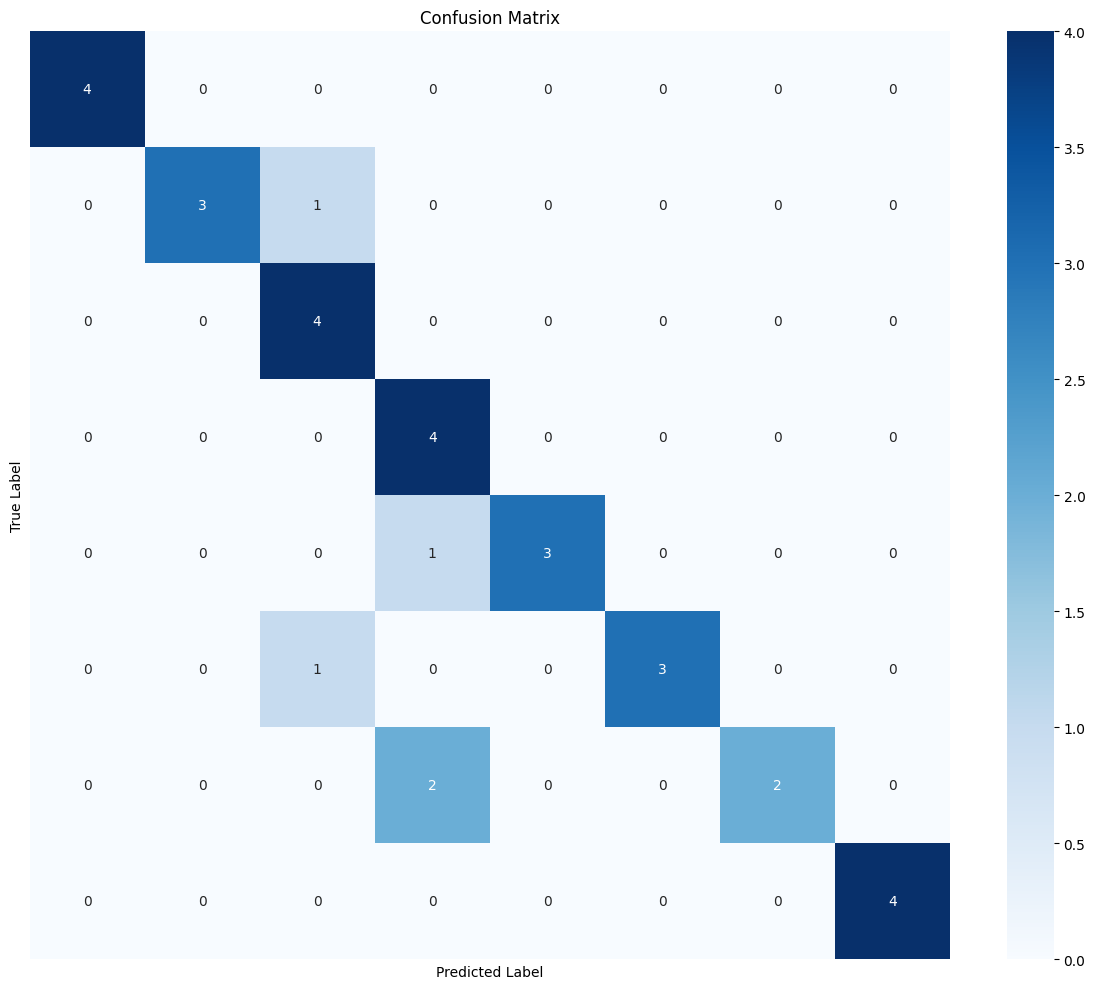


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      0.75      0.86         4
           2       0.67      1.00      0.80         4
           3       0.57      1.00      0.73         4
           4       1.00      0.75      0.86         4
           5       1.00      0.75      0.86         4
           6       1.00      0.50      0.67         4
           7       1.00      1.00      1.00         4

    accuracy                           0.84        32
   macro avg       0.90      0.84      0.85        32
weighted avg       0.90      0.84      0.85        32



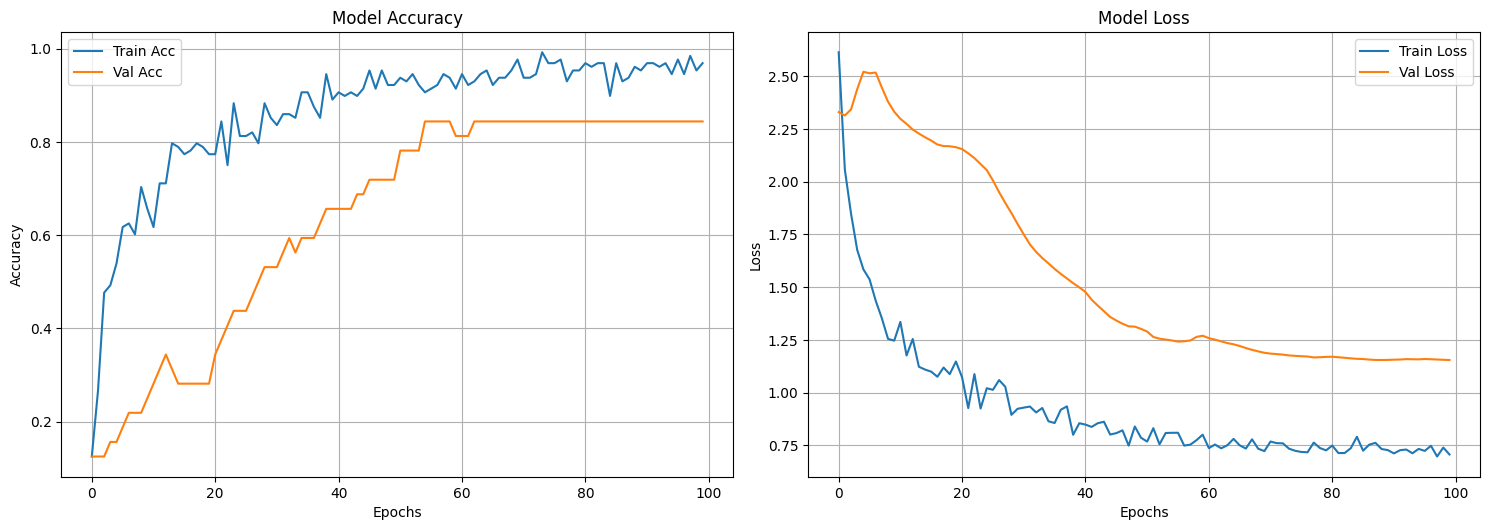

In [ ]:

# ========== STEP 6: Enhanced Evaluation & Visualization ============
# Evaluate on test set
loss, accuracy, f1_score = model.evaluate(X_test, y_test_cat, verbose=1)  # Assign the F1 score to f1_score
print(f"\n✅ Final Test Accuracy: {accuracy * 100:.2f}%")
print(f"\n✅ Final Test F1 Score: {f1_score * 100:.2f}%") # Print F1 score if needed


# Generate confusion matrix for detailed analysis
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Generate and plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

# Print detailed classification report
print("\nClassification Report:")

# Get the unique class labels from y_true (or y_train)
unique_classes = np.unique(y_true)

# Generate target names based on unique classes and le.classes_
target_names = [le.classes_[i] for i in unique_classes] if len(le.classes_) > 0 else [str(i) for i in unique_classes]

print(classification_report(y_true, y_pred, target_names=target_names)) # Use target_names here

# Plot training history with more metrics
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Calculate learning rates if we used LR reduction
if 'lr' in history.history:
    plt.subplot(2, 2, 3)
    plt.plot(history.history['lr'], label='Learning Rate')
    plt.title("Learning Rate")
    plt.xlabel("Epochs")
    plt.ylabel("LR")
    plt.grid(True)

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()